# Setup

## Import

In [1]:
from brian2 import *
from scipy.signal import savgol_filter
import pickle

In [2]:
import os.path
from os import path

## Saving
total_save_seconds = 180
save_path_leafs = ['60','120','180','240']
save_path_prefix = './out/long_run/'
##save_path_prefix = './out/test_run/'

if path.exists(save_path_prefix) == False:
    os.mkdir(save_path_prefix)

for p in range(60, total_save_seconds+60, 60):
  if path.exists(save_path_prefix + str(p)) == False:
    os.mkdir(save_path_prefix + str(p))

os.chdir(save_path_prefix)
!pwd
!ls


/home/talanov/brian2/bypass/out/long_run
120  180  60


In [3]:
!pwd

/home/talanov/brian2/bypass/out/long_run


## Defs

### Functions 

In [6]:
def generate_Izhi_neurons(neurons_n):
  neurons = NeuronGroup(neurons_n, 
                        '''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
                        dge/dt = -ge / taue : 1''',
                        threshold='v>vt', reset='v = vr',
                        method='exact')
  return neurons

def generate_STDP_DA_synapses(pre, post):
  """
    Generates the STDP modulated with DA synapses
    pre -- the presynaptic neurons 
    post -- the postsynaptic neurons 
    mode is external variable: mode = 0 switches off DA modulation, mode = 1 switches on DA modulation.
    """
  synapse_stdp = Synapses(pre, post,
                          model='''mode: 1
                          dc/dt = -c / tauc : 1 (clock-driven)
                          dd/dt = -d / taud : 1 (clock-driven)
                          ds/dt = mode * c * d / taus : 1 (clock-driven)
                          dApre/dt = -Apre / taupre : 1 (event-driven)
                          dApost/dt = -Apost / taupost : 1 (event-driven)''',
                          on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                          on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                          method='euler'
                          )
  return synapse_stdp

def generate_simple_synapses(pre, post):
  synapse = Synapses(pre, post, model='''s: volt''', on_pre='v += s')
  return synapse

def identity_cut_chank(step):
  ## cut_chank_number
  cut_chank_number = [0]
  if (step < 2):   cut_chank_number = [0]
  elif (step < 3): cut_chank_number = [0,1]
  elif (step < 4): cut_chank_number = [1]
  elif (step < 6): cut_chank_number = [1,2]
  elif (step < 7): cut_chank_number = [2]
  elif (step < 8): cut_chank_number = [2,3]
  elif (step < 10): cut_chank_number = [3]
  return cut_chank_number

def identity_cut_chank_no_intersections(step):
  ## cut_chank_number
  cut_chank_number = [0]
  if (step < 2):    cut_chank_number = [0]
  elif (step < 3):  cut_chank_number = [0]
  elif (step < 4):  cut_chank_number = [1]
  elif (step < 6):  cut_chank_number = [1]
  elif (step < 7):  cut_chank_number = [2]
  elif (step < 8):  cut_chank_number = [2]
  elif (step < 10): cut_chank_number = [3]
  return cut_chank_number

def identify_muscle_freq(step, freq_hi, freq_lo):
  if step in [2,3,6,7]: return freq_hi
  else: return freq_lo

def identify_V3_F_freq(step, freq_hi, freq_lo):
    ## [6,7]
    if step in [6,7]: return freq_hi
    else: return freq_lo

def identify_V0_freq(step, freq_hi, freq_lo):
    ## [6,7]
    if step in [6,7]: return freq_hi
    else: return freq_lo

def save_reset_spike_monitor(spike_monitor, save_path_prefix, file_name, neuron_group):
    print ('saving spike montor' + str(spike_monitor) + ' into: ' + save_path_prefix)
    data = spike_monitor.get_states(['t', 'i'])
    save_path_run = save_path_prefix + '/'
    print('save in ' + save_path_run + file_name + '.pickle')
    with open(save_path_run + file_name + '.pickle', 'wb') as f:
        pickle.dump(data, f)
        print('reset monitor')
        del spike_monitor
        del data
        print('creating new monitor')
        res_monitor = SpikeMonitor(neuron_group)
        return res_monitor

def save_reset_state_monitor(state_monitor, save_path_prefix, file_name, state, monitor_dt, group):
    print ('saving state montor' + str(state_monitor))
    data = state_monitor.get_states(['t', state])
    save_path_run = save_path_prefix + '/'
    print('save '+ str(state) + ' in ' + save_path_run + file_name + '.pickle')
    with open(save_path_run + file_name + '.pickle', 'wb') as f:
        pickle.dump(data, f)
        print('reset monitor')
        del state_monitor
        del data
        print('creating new monitor')
        res_monitor = StateMonitor(group, state, record=True, dt=monitor_dt)
        return res_monitor

print('Completed functions definitions ...')

Completed functions definitions ...


## Parameters: 5 steps

In [15]:
# Parameters
step_duration = 1000 ## ms
swing_stance_duration = 500 ##ms
simulation_hill_toe_phases = 4
simulation_muscle_phases = 5
simulation_step_phases = 10
steps_num = 5 # 120

cut2rg_conn_probability = 0.7 # 0.01 ## 0.02 ## cut -> rg
muscle2rg_conn_probability = 0.1 # 0.1 ## 0.02 ## muscle -> rg
V3_F_2rg_conn_probability = 0.1 ## V3-F -> rg
rg2motor_conn_probability = 0.1 ## rg -> motor

cut_stdp_synapse_probability = 0.9 # 0.9 ## 0.1 ## cut -> rg
muscle_stdp_synapse_probability = 0.9 # 0.9 ## 0.1 ## cut -> rg

cut2Ia_conn_probability = 0.1 ## cut -> Ia
muscle2Ia_conn_probability = 0.2 ## muscle -> Ia
Ia2motor_conn_probability = 0.2
V0d_conn_probability = 0.2
V2a_conn_probability = 0.2
V0v_conn_probability = 0.2
In1_conn_probability = 0.2

cut_fibers_num = 100 ## 24 ## 100
cut_fibers_freq = 50*Hz #200*Hz

muscle_fibers_num = 100 # 8 #100
# [20,50,20,50,20]*Hz
muscle_fibers_freq_hi = 50*Hz
muscle_fibers_freq_lo = 20*Hz

V3_F_num = 200
V3_F_freq_lo = 5*Hz 
V3_F_freq_hi = 200*Hz 

V0v_num = 200
V2a_num = 200
In1_num = 200
V0d_num = 200
In_num = 200

Ia_num = 100
rg_num = 200 # 48 # 200
motor_num = 200 # 48 # 200

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
stdp_monitor_dt= 20*ms ##5*ms
delay_max = 3*ms

## Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

print('Parameters set')

Parameters set


## Network 2 legs

![](https://raw.githubusercontent.com/max-talanov/1/master/bypass/v0v-v0d.png)


### Left leg

![](https://www.frontiersin.org/files/Articles/1124950/fnins-17-1124950-HTML/image_m/fnins-17-1124950-g001.jpg)

In [16]:
# Setting the stage
start_scope()

# Extensor
# Inputs
l_e_poisson_cut_input = PoissonGroup(cut_fibers_num, rates=cut_fibers_freq)
l_e_poisson_muscle_input = PoissonGroup(muscle_fibers_num, rates=muscle_fibers_freq_lo)
# Rythm generators
l_e_rg_neurons = generate_Izhi_neurons(rg_num)
l_e_rg_neurons.v = vr
# Motor neurons
l_e_motor_neurons = generate_Izhi_neurons(motor_num)
l_e_motor_neurons.v = vr
## synapse = generate_simple_synapses(spike_input, neurons)
l_e_cut2rg = generate_simple_synapses(l_e_poisson_cut_input, l_e_rg_neurons)
## e_cut2rg.connect(p=cut2rg_conn_probability)
l_e_cut2rg.connect(condition='j==2*i or j==(2*i+1)')
## e_cut2rg.connect(j='i')
l_e_cut2rg.s = 100. * mV

## synapse = generate_simple_synapses(spike_input, neurons)
l_e_muscle2rg = generate_simple_synapses(l_e_poisson_muscle_input, l_e_rg_neurons)
l_e_muscle2rg.connect(p=muscle2rg_conn_probability)
l_e_muscle2rg.s = 100. * mV

l_e_rg2motor = generate_simple_synapses(l_e_rg_neurons, l_e_motor_neurons)
## e_rg2motor.connect(p=rg2motor_conn_probability) 
l_e_rg2motor.connect(j='i') 
l_e_rg2motor.s = 100. * mV

l_e_cut2rg_stdp = generate_STDP_DA_synapses(l_e_poisson_cut_input, l_e_rg_neurons)
l_e_cut2rg_stdp.connect(p=cut_stdp_synapse_probability)
l_e_cut2rg_stdp.mode = 0
l_e_cut2rg_stdp.s = 1e-10
l_e_cut2rg_stdp.c = 1e-10
l_e_cut2rg_stdp.d = 0
# e_cut2rg_stdp.s = 'rand() * 2 * gmax - gmax'
l_e_cut2rg_stdp.pre.delay = 'rand() * delay_max'

##muscle stdp synapses
l_e_muscle2rg_stdp = generate_STDP_DA_synapses(l_e_poisson_muscle_input, l_e_rg_neurons)
l_e_muscle2rg_stdp.connect(p=cut_stdp_synapse_probability)
l_e_muscle2rg_stdp.mode = 0
l_e_muscle2rg_stdp.s = 1e-10
l_e_muscle2rg_stdp.c = 1e-10
l_e_muscle2rg_stdp.d = 0
# l_e_muscle2rg_stdp.s = 'rand() * 2 * gmax - gmax'
l_e_muscle2rg_stdp.pre.delay = 'rand() * delay_max'

l_e_muscle2rg_stdp

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_3')

In [17]:
## Flexor
# Inputs
l_f_poisson_V3_F_input = PoissonGroup(V3_F_num, rates=V3_F_freq_lo)
l_f_poisson_muscle_input = PoissonGroup(muscle_fibers_num, rates=muscle_fibers_freq_lo)
# Rythm generators
l_f_rg_neurons = generate_Izhi_neurons(rg_num)
l_f_rg_neurons.v = vr
# Motor neurons
l_f_motor_neurons = generate_Izhi_neurons(motor_num)
l_f_motor_neurons.v = vr

## synapse = generate_simple_synapses(spike_input, neurons)
l_f_muscle2rg = generate_simple_synapses(l_f_poisson_muscle_input, l_f_rg_neurons)
l_f_muscle2rg.connect(p=muscle2rg_conn_probability)
l_f_muscle2rg.s = 100. * mV

l_f_V3_F_2rg = generate_simple_synapses(l_f_poisson_V3_F_input, l_f_rg_neurons)
l_f_V3_F_2rg.connect(p=V3_F_2rg_conn_probability)
l_f_V3_F_2rg.s = 100. * mV

l_f_rg2motor = generate_simple_synapses(l_f_rg_neurons, l_f_motor_neurons)
## f_rg2motor.connect(p=rg2motor_conn_probability)
l_f_rg2motor.connect(j='i')
l_f_rg2motor.s = 100. * mV

l_f_muscle2rg_stdp = generate_STDP_DA_synapses(l_f_poisson_muscle_input, l_f_rg_neurons)
l_f_muscle2rg_stdp.connect(p=cut_stdp_synapse_probability)
l_f_muscle2rg_stdp.mode = 0
l_f_muscle2rg_stdp.s = 1e-10
l_f_muscle2rg_stdp.c = 1e-10
l_f_muscle2rg_stdp.d = 0
## l_f_muscle2rg_stdp.s = 'rand() * 2 * gmax - gmax'
l_f_muscle2rg_stdp.pre.delay = 'rand() * delay_max'

l_f_muscle2rg_stdp

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_6')

In [18]:
## Inhibitory F<->E projections
# Ia interneurons
# Extensor
l_e_Ia_neurons = generate_Izhi_neurons(Ia_num)
l_e_Ia_neurons.v = vr
l_e_muscle2Ia = generate_simple_synapses(l_e_poisson_muscle_input, l_e_Ia_neurons)
l_e_muscle2Ia.connect(p=muscle2Ia_conn_probability) 
l_e_muscle2Ia.s = 100. * mV
# Inhibitory synapses
l_e_Ia2motor = generate_simple_synapses(l_e_Ia_neurons, l_f_motor_neurons)
l_e_Ia2motor.connect(p=Ia2motor_conn_probability) 
l_e_Ia2motor.s = -100. * mV

# Flexor
l_f_Ia_neurons = generate_Izhi_neurons(Ia_num)
l_f_Ia_neurons.v = vr
l_f_muscle2Ia = generate_simple_synapses(l_f_poisson_muscle_input, l_f_Ia_neurons)
l_f_muscle2Ia.connect(p=muscle2Ia_conn_probability) 
l_f_muscle2Ia.s = 100. * mV
# Inhibitory synapses
l_f_Ia2motor = generate_simple_synapses(l_f_Ia_neurons, l_e_motor_neurons)
l_f_Ia2motor.connect(p=Ia2motor_conn_probability) 
l_f_Ia2motor.s = -100. * mV
l_f_Ia2motor

# InE
l_e_InE_neurons = generate_Izhi_neurons(In_num)
l_e_InE_neurons.v = vr
l_e_rg2InE = generate_simple_synapses(l_e_rg_neurons, l_e_InE_neurons)
l_e_rg2InE.connect(p=muscle2Ia_conn_probability) 
l_e_rg2InE.s = 100. * mV
# Inhibitory synapses
l_e_InE2f_rg = generate_simple_synapses(l_e_InE_neurons, l_f_rg_neurons)
l_e_InE2f_rg.connect(p=Ia2motor_conn_probability) 
l_e_InE2f_rg.s = -100. * mV

# InF
l_f_InF_neurons = generate_Izhi_neurons(In_num)
l_f_InF_neurons.v = vr
l_f_rg2InF = generate_simple_synapses(l_f_rg_neurons, l_f_InF_neurons)
l_f_rg2InF.connect(p=muscle2Ia_conn_probability) 
l_f_rg2InF.s = 100. * mV
# Inhibitory synapses
l_f_InF2f_rg = generate_simple_synapses(l_f_InF_neurons, l_e_rg_neurons)
l_f_InF2f_rg.connect(p=Ia2motor_conn_probability) 
l_f_InF2f_rg.s = -100. * mV

l_f_InF2f_rg

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_28')

### Right leg

In [19]:
# Extensor
# Inputs
r_e_poisson_cut_input = PoissonGroup(cut_fibers_num, rates=cut_fibers_freq)
r_e_poisson_muscle_input = PoissonGroup(muscle_fibers_num, rates=muscle_fibers_freq_lo)
# Rythm generators
r_e_rg_neurons = generate_Izhi_neurons(rg_num)
r_e_rg_neurons.v = vr
# Motor neurons
r_e_motor_neurons = generate_Izhi_neurons(motor_num)
r_e_motor_neurons.v = vr
## synapse = generate_simple_synapses(spike_input, neurons)
r_e_cut2rg = generate_simple_synapses(r_e_poisson_cut_input, r_e_rg_neurons)
## r_e_cut2rg.connect(p=cut2rg_conn_probability)
r_e_cut2rg.connect(condition='j==2*i or j==(2*i+1)')
## r_e_cut2rg.connect(j='i')
r_e_cut2rg.s = 100. * mV

## synapse = generate_simple_synapses(spike_input, neurons)
r_e_muscle2rg = generate_simple_synapses(r_e_poisson_muscle_input, r_e_rg_neurons)
r_e_muscle2rg.connect(p=muscle2rg_conn_probability)
r_e_muscle2rg.s = 100. * mV

r_e_rg2motor = generate_simple_synapses(r_e_rg_neurons, r_e_motor_neurons)
## r_e_rg2motor.connect(p=rg2motor_conn_probability) 
r_e_rg2motor.connect(j='i') 
r_e_rg2motor.s = 100. * mV

r_e_cut2rg_stdp = generate_STDP_DA_synapses(r_e_poisson_cut_input, r_e_rg_neurons)
r_e_cut2rg_stdp.connect(p=cut_stdp_synapse_probability)
r_e_cut2rg_stdp.mode = 0
r_e_cut2rg_stdp.s = 1e-10
r_e_cut2rg_stdp.c = 1e-10
r_e_cut2rg_stdp.d = 0
# r_e_cut2rg_stdp.s = 'rand() * 2 * gmax - gmax'
r_e_cut2rg_stdp.pre.delay = 'rand() * delay_max'
##TODO add muscle stdp synapses

r_e_cut2rg_stdp

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_16')

In [20]:
## Flexor
# Inputs

r_f_poisson_V3_F_input = PoissonGroup(V3_F_num, rates=V3_F_freq_lo)
r_f_poisson_muscle_input = PoissonGroup(muscle_fibers_num, rates=muscle_fibers_freq_lo)
# Rythm generators
r_f_rg_neurons = generate_Izhi_neurons(rg_num)
r_f_rg_neurons.v = vr
# Motor neurons
r_f_motor_neurons = generate_Izhi_neurons(motor_num)
r_f_motor_neurons.v = vr

## synapse = generate_simple_synapses(spike_input, neurons)
r_f_muscle2rg = generate_simple_synapses(r_f_poisson_muscle_input, r_f_rg_neurons)
r_f_muscle2rg.connect(p=muscle2rg_conn_probability)
r_f_muscle2rg.s = 100. * mV

r_f_V3_F_2rg = generate_simple_synapses(r_f_poisson_V3_F_input, r_f_rg_neurons)
r_f_V3_F_2rg.connect(p=V3_F_2rg_conn_probability)
r_f_V3_F_2rg.s = 100. * mV

r_f_rg2motor = generate_simple_synapses(r_f_rg_neurons, r_f_motor_neurons)
## r_f_rg2motor.connect(p=rg2motor_conn_probability)
r_f_rg2motor.connect(j='i')
r_f_rg2motor.s = 100. * mV

r_f_muscle2rg_stdp = generate_STDP_DA_synapses(r_f_poisson_muscle_input, r_f_rg_neurons)
r_f_muscle2rg_stdp.connect(p=cut_stdp_synapse_probability)
r_f_muscle2rg_stdp.mode = 0
r_f_muscle2rg_stdp.s = 1e-10
r_f_muscle2rg_stdp.c = 1e-10
r_f_muscle2rg_stdp.d = 0
## r_f_muscle2rg_stdp.s = 'rand() * 2 * gmax - gmax'
r_f_muscle2rg_stdp.pre.delay = 'rand() * delay_max'
##TODO add muscle stdp synapses

r_f_muscle2rg_stdp

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_20')

In [21]:
## Inhibitory F<->E projections
# Ia interneurons
# Extensor
r_e_Ia_neurons = generate_Izhi_neurons(Ia_num)
r_e_Ia_neurons.v = vr

r_e_muscle2Ia = generate_simple_synapses(r_e_poisson_muscle_input, r_e_Ia_neurons)
r_e_muscle2Ia.connect(p=muscle2Ia_conn_probability) 
r_e_muscle2Ia.s = 100. * mV
# Inhibitory synapses
r_e_Ia2motor = generate_simple_synapses(r_e_Ia_neurons, r_f_motor_neurons)
r_e_Ia2motor.connect(p=Ia2motor_conn_probability) 
r_e_Ia2motor.s = -100. * mV

# Flexor
r_f_Ia_neurons = generate_Izhi_neurons(Ia_num)
r_f_Ia_neurons.v = vr
r_f_muscle2Ia = generate_simple_synapses(r_f_poisson_muscle_input, r_f_Ia_neurons)
r_f_muscle2Ia.connect(p=muscle2Ia_conn_probability) 
r_f_muscle2Ia.s = 100. * mV
# Inhibitory synapses
r_f_Ia2motor = generate_simple_synapses(r_f_Ia_neurons, r_e_motor_neurons)
r_f_Ia2motor.connect(p=Ia2motor_conn_probability) 
r_f_Ia2motor.s = -100. * mV

# InE
r_e_InE_neurons = generate_Izhi_neurons(In_num)
r_e_InE_neurons.v = vr
r_e_rg2InE = generate_simple_synapses(r_e_rg_neurons, r_e_InE_neurons)
r_e_rg2InE.connect(p=muscle2Ia_conn_probability) 
r_e_rg2InE.s = 100. * mV
# Inhibitory synapses
r_e_InE2f_rg = generate_simple_synapses(r_e_InE_neurons, r_f_rg_neurons)
r_e_InE2f_rg.connect(p=Ia2motor_conn_probability) 
r_e_InE2f_rg.s = -100. * mV

# InF
r_f_InF_neurons = generate_Izhi_neurons(In_num)
r_f_InF_neurons.v = vr
r_f_rg2InF = generate_simple_synapses(r_f_rg_neurons, r_f_InF_neurons)
r_f_rg2InF.connect(p=muscle2Ia_conn_probability) 
r_f_rg2InF.s = 100. * mV
# Inhibitory synapses
r_f_InF2f_rg = generate_simple_synapses(r_f_InF_neurons, r_e_rg_neurons)
r_f_InF2f_rg.connect(p=Ia2motor_conn_probability) 
r_f_InF2f_rg.s = -100. * mV

r_f_InF2f_rg

Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_38')

In [22]:
# Inhibitory left<->right coordination 
## V0d
## Left leg
l_f_V0d_neurons = generate_Izhi_neurons(V0d_num)
l_f_V0d_neurons.v = vr
l_f_rg2V0d = generate_simple_synapses(l_f_rg_neurons, l_f_V0d_neurons)
l_f_rg2V0d.connect(p=V0d_conn_probability) 
l_f_rg2V0d.s = 100. * mV
# Inhibitory synapses
l_f_V0d2r_f_rg = generate_simple_synapses(l_f_V0d_neurons, r_f_rg_neurons)
l_f_V0d2r_f_rg.connect(p=V0d_conn_probability) 
l_f_V0d2r_f_rg.s = -100. * mV
l_f_V0d2r_f_rg

## Right leg
r_f_V0d_neurons = generate_Izhi_neurons(V0d_num)
r_f_V0d_neurons.v = vr
r_f_rg2V0d = generate_simple_synapses(r_f_rg_neurons, r_f_V0d_neurons)
r_f_rg2V0d.connect(p=V0d_conn_probability) 
r_f_rg2V0d.s = 100. * mV
# Inhibitory synapses
r_f_V0d2r_f_rg = generate_simple_synapses(r_f_V0d_neurons, l_f_rg_neurons)
r_f_V0d2r_f_rg.connect(p=V0d_conn_probability) 
r_f_V0d2r_f_rg.s = -100. * mV
r_f_V0d2r_f_rg

## V0v
## Neurons
## Left leg
l_f_V2a_neurons = generate_Izhi_neurons(V2a_num)
l_f_V2a_neurons.v = vr
l_f_V0v_neurons = generate_Izhi_neurons(V0v_num)
l_f_V0v_neurons.v = vr
l_f_In1_neurons = generate_Izhi_neurons(In1_num)
l_f_In1_neurons.v = vr
## Right leg
r_f_V2a_neurons = generate_Izhi_neurons(V2a_num)
r_f_V2a_neurons.v = vr
r_f_V0v_neurons = generate_Izhi_neurons(V0v_num)
r_f_V0v_neurons.v = vr
r_f_In1_neurons = generate_Izhi_neurons(In1_num)
r_f_In1_neurons.v = vr

## Left leg
# Synapses 
l_f_rg2V2a = generate_simple_synapses(l_f_rg_neurons, l_f_V2a_neurons)
l_f_rg2V2a.connect(p=V2a_conn_probability) 
l_f_rg2V2a.s = 100. * mV
l_f_V2a2f_V0v = generate_simple_synapses(l_f_V2a_neurons, l_f_V0v_neurons)
l_f_V2a2f_V0v.connect(p=V0v_conn_probability) 
l_f_V2a2f_V0v.s = 100. * mV
l_f_V0v2r_f_In1 = generate_simple_synapses(l_f_V0v_neurons, r_f_In1_neurons)
l_f_V0v2r_f_In1.connect(p=V0v_conn_probability) 
l_f_V0v2r_f_In1.s = 100. * mV
r_f_In12r_f_rg = generate_simple_synapses(r_f_In1_neurons, r_f_rg_neurons)
r_f_In12r_f_rg.connect(p=V0v_conn_probability) 
r_f_In12r_f_rg.s = -100. * mV


## Right leg
# Synapses 
r_f_rg2V2a = generate_simple_synapses(r_f_rg_neurons, r_f_V2a_neurons)
r_f_rg2V2a.connect(p=V2a_conn_probability) 
r_f_rg2V2a.s = 100. * mV
r_f_V2a2f_V0v = generate_simple_synapses(r_f_V2a_neurons, r_f_V0v_neurons)
r_f_V2a2f_V0v.connect(p=V0v_conn_probability) 
r_f_V2a2f_V0v.s = 100. * mV
r_f_V0v1l_f_In1 = generate_simple_synapses(r_f_V0v_neurons, l_f_In1_neurons)
r_f_V0v1l_f_In1.connect(p=V0v_conn_probability) 
r_f_V0v1l_f_In1.s = 100. * mV
l_f_In12l_f_rg = generate_simple_synapses(l_f_In1_neurons, l_f_rg_neurons)
l_f_In12l_f_rg.connect(p=V0v_conn_probability) 
l_f_In12l_f_rg.s = -100. * mV
l_f_In12l_f_rg


Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_50')

## Monitors

In [23]:
# Left leg
## Extensor
l_e_cut_monitor = SpikeMonitor(l_e_poisson_cut_input)
l_e_muscle_monitor = SpikeMonitor(l_e_poisson_muscle_input)
l_e_rg_neurons_monitor = SpikeMonitor(l_e_rg_neurons)
l_e_motor_neurons_monitor = SpikeMonitor(l_e_motor_neurons)
l_e_Ia_neurons_monitor = SpikeMonitor(l_e_Ia_neurons)
l_e_motor_neurons_voltages = StateMonitor(l_e_motor_neurons, 'v', record=True, dt=stdp_monitor_dt)
l_e_cut2rg_stdp_monitor = StateMonitor(l_e_cut2rg_stdp, 's', record=True, dt=stdp_monitor_dt)

## Flexor
l_f_muscle_monitor = SpikeMonitor(l_f_poisson_muscle_input)
l_f_V3_F_monitor = SpikeMonitor(l_f_poisson_V3_F_input)
l_f_rg_neurons_monitor = SpikeMonitor(l_f_rg_neurons)
l_f_motor_neurons_monitor = SpikeMonitor(l_f_motor_neurons)
l_f_Ia_neurons_monitor = SpikeMonitor(l_f_Ia_neurons)
l_f_V0d_neurons_monitor = SpikeMonitor(l_f_V0d_neurons)
l_f_In1_neurons_monitor = SpikeMonitor(l_f_In1_neurons)

l_f_motor_neurons_voltages = StateMonitor(l_f_motor_neurons, 'v', record=True, dt=stdp_monitor_dt)
l_f_muscle2rg_stdp_monitor = StateMonitor(l_f_muscle2rg_stdp, 's', record=True, dt=stdp_monitor_dt)
l_f_muscle2rg_stdp_monitor

# Right leg
## Extensor
r_e_cut_monitor = SpikeMonitor(r_e_poisson_cut_input)
r_e_muscle_monitor = SpikeMonitor(r_e_poisson_muscle_input)
r_e_rg_neurons_monitor = SpikeMonitor(r_e_rg_neurons)
r_e_motor_neurons_monitor = SpikeMonitor(r_e_motor_neurons)
r_e_Ia_neurons_monitor = SpikeMonitor(r_e_Ia_neurons)
r_e_motor_neurons_voltages = StateMonitor(r_e_motor_neurons, 'v', record=True, dt=stdp_monitor_dt)
r_e_cut2rg_stdp_monitor = StateMonitor(r_e_cut2rg_stdp, 's', record=True, dt=stdp_monitor_dt)

## Flexor
r_f_muscle_monitor = SpikeMonitor(r_f_poisson_muscle_input)
r_f_V3_F_monitor = SpikeMonitor(r_f_poisson_V3_F_input)
r_f_rg_neurons_monitor = SpikeMonitor(r_f_rg_neurons)
r_f_motor_neurons_monitor = SpikeMonitor(r_f_motor_neurons)
r_f_Ia_neurons_monitor = SpikeMonitor(r_f_Ia_neurons)
r_f_V0d_neurons_monitor = SpikeMonitor(r_f_V0d_neurons)
r_f_In1_neurons_monitor = SpikeMonitor(r_f_In1_neurons)

r_f_motor_neurons_voltages = StateMonitor(r_f_motor_neurons, 'v', record=True, dt=stdp_monitor_dt)
r_f_muscle2rg_stdp_monitor = StateMonitor(r_f_muscle2rg_stdp, 's', record=True, dt=stdp_monitor_dt)
r_f_muscle2rg_stdp_monitor


<StateMonitor, recording ['s'] from 'synapses_20'>

# Run 
![](https://raw.githubusercontent.com/max-talanov/1/master/bypass/step_phases.png)

In [24]:
!pwd

/home/talanov/brian2/bypass/out/long_run


In [25]:
# Simulation
## Classical STDP
#synapse_stdp.mode = 0

## Split simulation in N chanks and switch on sequentally 
dur = int(swing_stance_duration/simulation_step_phases)
cut_chank = int(len(l_e_poisson_cut_input)/simulation_hill_toe_phases)
print('Simulation started ...')
## print (dur)
## print (cut_chank)
steps_to_save = 60
save_path_prefix = './'

for step in range(steps_num): 
    print ('step=' + str(step))
    ## TODO update into swing and stance
    if ((step % steps_to_save) == 0) and step > 0:
        save_path_run = save_path_prefix + str(step)
        # Left leg
        ## Extensor 
        # Save states
        l_e_synapse_stdp_monitor=save_reset_state_monitor(l_e_cut2rg_stdp_monitor, save_path_run, 
                                                        'l_e_cut2rg_weigts', 's', 
                                                  stdp_monitor_dt, l_e_cut2rg_stdp)
        l_e_motor_neurons_voltages=save_reset_state_monitor(l_e_motor_neurons_voltages, save_path_run, 
                                                    'l_e_motor_neurons_voltages', 'v', 
                                                    stdp_monitor_dt, l_e_motor_neurons)
        # Save spikes
        l_e_motor_neurons_monitor=save_reset_spike_monitor(l_e_motor_neurons_monitor, save_path_run, 
                                                   'l_e_motor_neurons_spikes', l_e_motor_neurons)
        l_e_rg_neurons_monitor=save_reset_spike_monitor(l_e_rg_neurons_monitor, save_path_run, 
                                                   'l_e_rg_neurons_spikes', l_e_rg_neurons)
        l_e_cut_monitor=save_reset_spike_monitor(l_e_cut_monitor, save_path_run, 
                                                   'l_e_cut_spikes', l_e_poisson_cut_input)
        l_e_muscle_monitor=save_reset_spike_monitor(l_e_muscle_monitor, save_path_run, 
                                                   'l_e_muscle_spikes', l_e_poisson_muscle_input)
        l_e_Ia_neurons_monitor=save_reset_spike_monitor(l_e_Ia_neurons_monitor, save_path_run, 
                                                   'l_e_Ia_spikes', l_e_Ia_neurons)
  
        ## Flexor 
        # Save states
        l_f_synapse_stdp_monitor=save_reset_state_monitor(l_f_muscle2rg_stdp_monitor, save_path_run, 
                                                        'l_f_muscle2rg_weigts', 's', 
                                                        stdp_monitor_dt, l_f_muscle2rg_stdp)
        l_f_motor_neurons_voltages=save_reset_state_monitor(l_f_motor_neurons_voltages, save_path_run, 
                                                          'l_f_motor_neurons_voltages', 'v', 
                                                          stdp_monitor_dt, l_f_motor_neurons)
        # Save spikes
        l_f_motor_neurons_monitor=save_reset_spike_monitor(l_f_motor_neurons_monitor, save_path_run, 
                                                   'l_f_motor_neurons_spikes', l_f_motor_neurons)
        l_f_rg_neurons_monitor=save_reset_spike_monitor(l_f_rg_neurons_monitor, save_path_run, 
                                                   'l_f_rg_neurons_spikes', l_f_rg_neurons)
        l_f_muscle_monitor=save_reset_spike_monitor(l_f_muscle_monitor, save_path_run, 
                                                   'l_f_muscle_spikes', l_f_poisson_muscle_input)
        l_f_V3_F_monitor=save_reset_spike_monitor(l_f_V3_F_monitor, save_path_run, 
                                                   'l_f_V3_F_spikes', l_f_poisson_V3_F_input)
        l_f_Ia_neurons_monitor=save_reset_spike_monitor(l_f_Ia_neurons_monitor, save_path_run, 
                                                   'l_f_Ia_spikes', l_f_Ia_neurons)
        l_f_V0d_neurons_monitor=save_reset_spike_monitor(l_f_V0d_neurons_monitor, save_path_run, 
                                                   'l_f_V0d_spikes', l_f_V0d_neurons)
        l_f_In1_neurons_monitor=save_reset_spike_monitor(l_f_In1_neurons_monitor, save_path_run, 
                                                   'l_f_In1_spikes', l_f_In1_neurons)
        
        # Right leg
        ## Extensor 
        # Save states
        r_e_synapse_stdp_monitor=save_reset_state_monitor(r_e_cut2rg_stdp_monitor, save_path_run, 
                                                        'r_e_cut2rg_weigts', 's', 
                                                  stdp_monitor_dt, r_e_cut2rg_stdp)
        r_e_motor_neurons_voltages=save_reset_state_monitor(r_e_motor_neurons_voltages, save_path_run, 
                                                    'r_e_motor_neurons_voltages', 'v', 
                                                    stdp_monitor_dt, r_e_motor_neurons)
        # Save spikes
        r_e_motor_neurons_monitor=save_reset_spike_monitor(r_e_motor_neurons_monitor, save_path_run, 
                                                   'r_e_motor_neurons_spikes', r_e_motor_neurons)
        r_e_rg_neurons_monitor=save_reset_spike_monitor(r_e_rg_neurons_monitor, save_path_run, 
                                                   'r_e_rg_neurons_spikes', r_e_rg_neurons)
        r_e_cut_monitor=save_reset_spike_monitor(r_e_cut_monitor, save_path_run, 
                                                   'r_e_cut_spikes', r_e_poisson_cut_input)
        r_e_muscle_monitor=save_reset_spike_monitor(r_e_muscle_monitor, save_path_run, 
                                                   'r_e_muscle_spikes', r_e_poisson_muscle_input)
        r_e_Ia_neurons_monitor=save_reset_spike_monitor(r_e_Ia_neurons_monitor, save_path_run, 
                                                   'r_e_Ia_spikes', r_e_Ia_neurons)  
        ## Flexor 
        # Save states
        r_f_synapse_stdp_monitor=save_reset_state_monitor(r_f_muscle2rg_stdp_monitor, save_path_run, 
                                                        'r_f_muscle2rg_weigts', 's', 
                                                        stdp_monitor_dt, r_f_muscle2rg_stdp)
        r_f_motor_neurons_voltages=save_reset_state_monitor(r_f_motor_neurons_voltages, save_path_run, 
                                                          'r_f_motor_neurons_voltages', 'v', 
                                                          stdp_monitor_dt, r_f_motor_neurons)
        # Save spikes
        r_f_motor_neurons_monitor=save_reset_spike_monitor(r_f_motor_neurons_monitor, save_path_run, 
                                                   'r_f_motor_neurons_spikes', r_f_motor_neurons)
        r_f_rg_neurons_monitor=save_reset_spike_monitor(r_f_rg_neurons_monitor, save_path_run, 
                                                   'r_f_rg_neurons_spikes', r_f_rg_neurons)
        r_f_muscle_monitor=save_reset_spike_monitor(r_f_muscle_monitor, save_path_run, 
                                                   'r_f_muscle_spikes', r_f_poisson_muscle_input)
        r_f_V3_F_monitor=save_reset_spike_monitor(l_f_V3_F_monitor, save_path_run, 
                                                   'r_f_V3_F_spikes', r_f_poisson_V3_F_input)
        r_f_Ia_neurons_monitor=save_reset_spike_monitor(l_f_Ia_neurons_monitor, save_path_run, 
                                                   'r_f_Ia_spikes', r_f_Ia_neurons)
        r_f_V0d_neurons_monitor = save_reset_spike_monitor(r_f_V0d_neurons_monitor, save_path_run, 
                                                   'r_f_V0d_spikes', r_f_V0d_neurons)
        r_f_In1_neurons_monitor = save_reset_spike_monitor(r_f_In1_neurons_monitor, save_path_run, 
                                                   'r_f_In1_spikes', r_f_In1_neurons)

    
    ## Left leg: Stance phase
    ## Right leg: Swing phase
    l_e_poisson_cut_input.rates = 0*Hz
    l_e_poisson_muscle_input.rates = 0*Hz
    l_f_poisson_muscle_input.rates = 0*Hz
    l_f_poisson_V3_F_input.rates = 0*Hz
    r_f_poisson_muscle_input.rates = 0*Hz
    r_f_poisson_V3_F_input.rates = 0*Hz
    r_e_poisson_cut_input.rates = 0*Hz
    r_e_poisson_muscle_input.rates = 0*Hz
    for phase in range(simulation_step_phases):
        ### Left leg
        ## print ('stance phase=' + str(phase))
        l_e_cut_chank_number = identity_cut_chank(phase)
        # e_cut_chank_number = identity_cut_chank_no_intersections(phase)
        l_e_muscle_chank_freq = identify_muscle_freq(phase, muscle_fibers_freq_hi, muscle_fibers_freq_lo)
        ## print (cut_chank_number)
        ## print (muscle_chank_freq)
        l_e_poisson_cut_input[:].rates = 0*Hz
        for cn in l_e_cut_chank_number:
            ## print (str(cn*cut_chank) + ": " + str((cn+1)*cut_chank-1))
            l_e_poisson_cut_input[cn*cut_chank:(cn+1)*cut_chank-1].rates = 200*Hz
            ## print (poisson_cut_input)
        l_e_poisson_muscle_input.rates = l_e_muscle_chank_freq
        ### Right leg
        ## print ('swing phase=' + str(phase))
        r_f_muscle_chank_freq = identify_muscle_freq(phase, muscle_fibers_freq_hi, muscle_fibers_freq_lo)
        r_f_V3_F_chank_freq = identify_V3_F_freq(phase, V3_F_freq_hi, V3_F_freq_lo)
        ## print (muscle_chank_freq)
        r_f_poisson_muscle_input.rates = r_f_muscle_chank_freq
        r_f_poisson_V3_F_input.rates = r_f_V3_F_chank_freq
        
        run(dur*ms)
        ## run(dur*ms, report='text')
    
    ## Left leg: Swing phase
    ## Rigt leg: Stance phase 
    l_e_poisson_cut_input.rates = 0*Hz
    l_e_poisson_muscle_input.rates = 0*Hz
    l_f_poisson_muscle_input.rates = 0*Hz
    l_f_poisson_V3_F_input.rates = 0*Hz
    r_f_poisson_muscle_input.rates = 0*Hz
    r_f_poisson_V3_F_input.rates = 0*Hz
    r_e_poisson_cut_input.rates = 0*Hz
    r_e_poisson_muscle_input.rates = 0*Hz
    for phase in range(simulation_step_phases):
        ### Left leg
        ## print ('swing phase=' + str(phase))
        l_f_muscle_chank_freq = identify_muscle_freq(phase, muscle_fibers_freq_hi, muscle_fibers_freq_lo)
        l_f_V3_F_chank_freq = identify_V3_F_freq(phase, V3_F_freq_hi, V3_F_freq_lo)
        ## print (muscle_chank_freq)
        l_f_poisson_muscle_input.rates = l_f_muscle_chank_freq
        l_f_poisson_V3_F_input.rates = l_f_V3_F_chank_freq
        
        ### Right leg
        ## print ('stance phase=' + str(phase))
        r_e_cut_chank_number = identity_cut_chank(phase)
        # e_cut_chank_number = identity_cut_chank_no_intersections(phase)
        r_e_muscle_chank_freq = identify_muscle_freq(phase, muscle_fibers_freq_hi, muscle_fibers_freq_lo)
        ## print (cut_chank_number)
        ## print (muscle_chank_freq)
        r_e_poisson_cut_input[:].rates = 0*Hz
        for cn in r_e_cut_chank_number:
            ## print (str(cn*cut_chank) + ": " + str((cn+1)*cut_chank-1))
            r_e_poisson_cut_input[cn*cut_chank:(cn+1)*cut_chank-1].rates = 200*Hz
            ## print (poisson_cut_input)
        r_e_poisson_muscle_input.rates = r_e_muscle_chank_freq
        
        run(dur*ms)
        ## run(dur*ms, report='text')
    
    
print('Simulation ended ...')

Simulation starts ...
step=0
step=1
step=2
step=3
step=4
Simulation ends ...


# Save data

In [26]:
save_steps_num = 60
if steps_num < 60:
    save_steps_num = 60
    
save_path = save_path_prefix + str(save_steps_num) + '/'
# https://brian2.readthedocs.io/en/stable/user/recording.html
## Left leg
## Extensor
# Save motor neurons voltages
l_e_motor_neuron_data = l_e_motor_neurons_voltages.get_states(['t', 'v'])
with open(save_path + 'l_e_motor_neurons_voltages.pickle', 'wb') as f:
  pickle.dump(l_e_motor_neuron_data, f)
# Save weights ⬆️ see above 
l_e_cut2rg_data = l_e_cut2rg_stdp_monitor.get_states(['t', 's'])
with open(save_path + 'l_e_cut2rg_weigts.pickle', 'wb') as f:
  pickle.dump(l_e_cut2rg_data, f)
print('Saved left leg E voltages')

Saved left leg E voltages


In [27]:
## Right leg
## Extensor
# Save motor neurons voltages
r_e_motor_neuron_data = r_e_motor_neurons_voltages.get_states(['t', 'v'])
with open(save_path + 'r_e_motor_neurons_voltages.pickle', 'wb') as f:
  pickle.dump(r_e_motor_neuron_data, f)
# Save weights ⬆️ see above 
r_e_cut2rg_data = r_e_cut2rg_stdp_monitor.get_states(['t', 's'])
with open(save_path + 'l_e_cut2rg_weigts.pickle', 'wb') as f:
  pickle.dump(r_e_cut2rg_data, f)
print('Saved right leg E voltages')

Saved right leg E voltages


In [28]:
## Left leg
## Extensor
# Save spikes 
l_e_motor_neuron_spikes = l_e_motor_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_e_motor_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(l_e_motor_neuron_spikes, f)

l_e_rg_neuron_spikes = l_e_rg_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_e_rg_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(l_e_rg_neuron_spikes, f)


l_e_cut_spikes = l_e_cut_monitor.get_states(['t', 'i'])
with open(save_path + 'l_e_cut_spikes.pickle', 'wb') as f:
  pickle.dump(l_e_cut_spikes, f)

l_e_Ia_spikes = l_e_Ia_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_e_Ia_spikes.pickle', 'wb') as f:
  pickle.dump(l_e_Ia_spikes, f)

l_e_muscle_spikes = l_e_muscle_monitor.get_states(['t', 'i'])
with open(save_path + 'l_e_muscle_spikes.pickle', 'wb') as f:
  pickle.dump(l_e_muscle_spikes, f)
print('Saved left leg E spikes')

Saved left leg E spikes


In [29]:
## Right leg
## Extensor
# Save spikes 
r_e_motor_neuron_spikes = r_e_motor_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_e_motor_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(r_e_motor_neuron_spikes, f)

r_e_rg_neuron_spikes = r_e_rg_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_e_rg_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(r_e_rg_neuron_spikes, f)


r_e_cut_spikes = r_e_cut_monitor.get_states(['t', 'i'])
with open(save_path + 'r_e_cut_spikes.pickle', 'wb') as f:
  pickle.dump(r_e_cut_spikes, f)

r_e_Ia_spikes = r_e_Ia_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_e_Ia_spikes.pickle', 'wb') as f:
  pickle.dump(r_e_Ia_spikes, f)

r_e_muscle_spikes = r_e_muscle_monitor.get_states(['t', 'i'])
with open(save_path + 'r_e_muscle_spikes.pickle', 'wb') as f:
  pickle.dump(r_e_muscle_spikes, f)
print('Saved right leg E spikes')


Saved right leg E spikes


In [30]:
## Left leg
## Flexor
# Save motor neurons voltages
l_f_motor_neuron_data = l_f_motor_neurons_voltages.get_states(['t', 'v'])
with open(save_path + 'l_f_motor_neurons_voltages.pickle', 'wb') as f:
  pickle.dump(l_f_motor_neuron_data, f)
# Save weights ⬆️ see above 
l_f_muscle2rg_data = l_f_muscle2rg_stdp_monitor.get_states(['t', 's'])
with open(save_path + 'l_f_muscle2rg_weigts.pickle', 'wb') as f:
  pickle.dump(l_f_muscle2rg_data, f)
print('Saved left leg F voltages')

Saved left leg F voltages


In [31]:
## Right leg
## Flexor
# Save motor neurons voltages
r_f_motor_neuron_data = r_f_motor_neurons_voltages.get_states(['t', 'v'])
with open(save_path + 'r_f_motor_neurons_voltages.pickle', 'wb') as f:
  pickle.dump(r_f_motor_neuron_data, f)
# Save weights ⬆️ see above 
r_f_muscle2rg_data = r_f_muscle2rg_stdp_monitor.get_states(['t', 's'])
with open(save_path + 'r_f_muscle2rg_weigts.pickle', 'wb') as f:
  pickle.dump(r_f_muscle2rg_data, f)
print('Saved right leg F voltages')

Saved right leg F voltages


In [32]:
## Left leg
# Save spikes 
l_f_motor_neuron_spikes = l_f_motor_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_motor_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_motor_neuron_spikes, f)

l_f_rg_neuron_spikes = l_f_rg_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_rg_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_rg_neuron_spikes, f)


l_f_Ia_spikes = l_f_Ia_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_Ia_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_Ia_spikes, f)


l_f_muscle_spikes = l_f_muscle_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_muscle_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_muscle_spikes, f)

l_f_V3_F_spikes = l_f_V3_F_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_V3_F_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_V3_F_spikes, f)

## r_f_V0d_neurons_monitor 
## r_f_In1_neurons_monitor 
l_f_V0d_spikes = l_f_V0d_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_V0d_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_V0d_spikes, f)

l_f_In1_spikes = l_f_In1_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'l_f_In1_spikes.pickle', 'wb') as f:
  pickle.dump(l_f_In1_spikes, f)


print('Saved left leg F spikes')

Saved left leg F spikes


In [33]:
## Right leg
# Save spikes 
r_f_motor_neuron_spikes = r_f_motor_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_motor_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_motor_neuron_spikes, f)

r_f_rg_neuron_spikes = r_f_rg_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_rg_neurons_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_rg_neuron_spikes, f)

r_f_Ia_spikes = r_f_Ia_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_Ia_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_Ia_spikes, f)

r_f_muscle_spikes = r_f_muscle_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_muscle_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_muscle_spikes, f)

r_f_V3_F_spikes = r_f_V3_F_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_V3_F_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_V3_F_spikes, f)

## r_f_V0d_neurons_monitor 
## r_f_In1_neurons_monitor 
r_f_V0d_spikes = r_f_V0d_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_V0d_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_V0d_spikes, f)

r_f_In1_spikes = r_f_In1_neurons_monitor.get_states(['t', 'i'])
with open(save_path + 'r_f_In1_spikes.pickle', 'wb') as f:
  pickle.dump(r_f_In1_spikes, f)


print('Saved right leg F spikes')

Saved right leg F spikes


# Visualisation

In [ ]:
# Visualisation
cut_indices, cut_times = cut_monitor.it
muscle_indices, muscle_times = muscle_monitor.it
rg_indices, rg_times = rg_neurons_monitor.it
motor_indices, motor_times = motor_neurons_monitor.it
len(cut_times)

55961

## Spiketimes

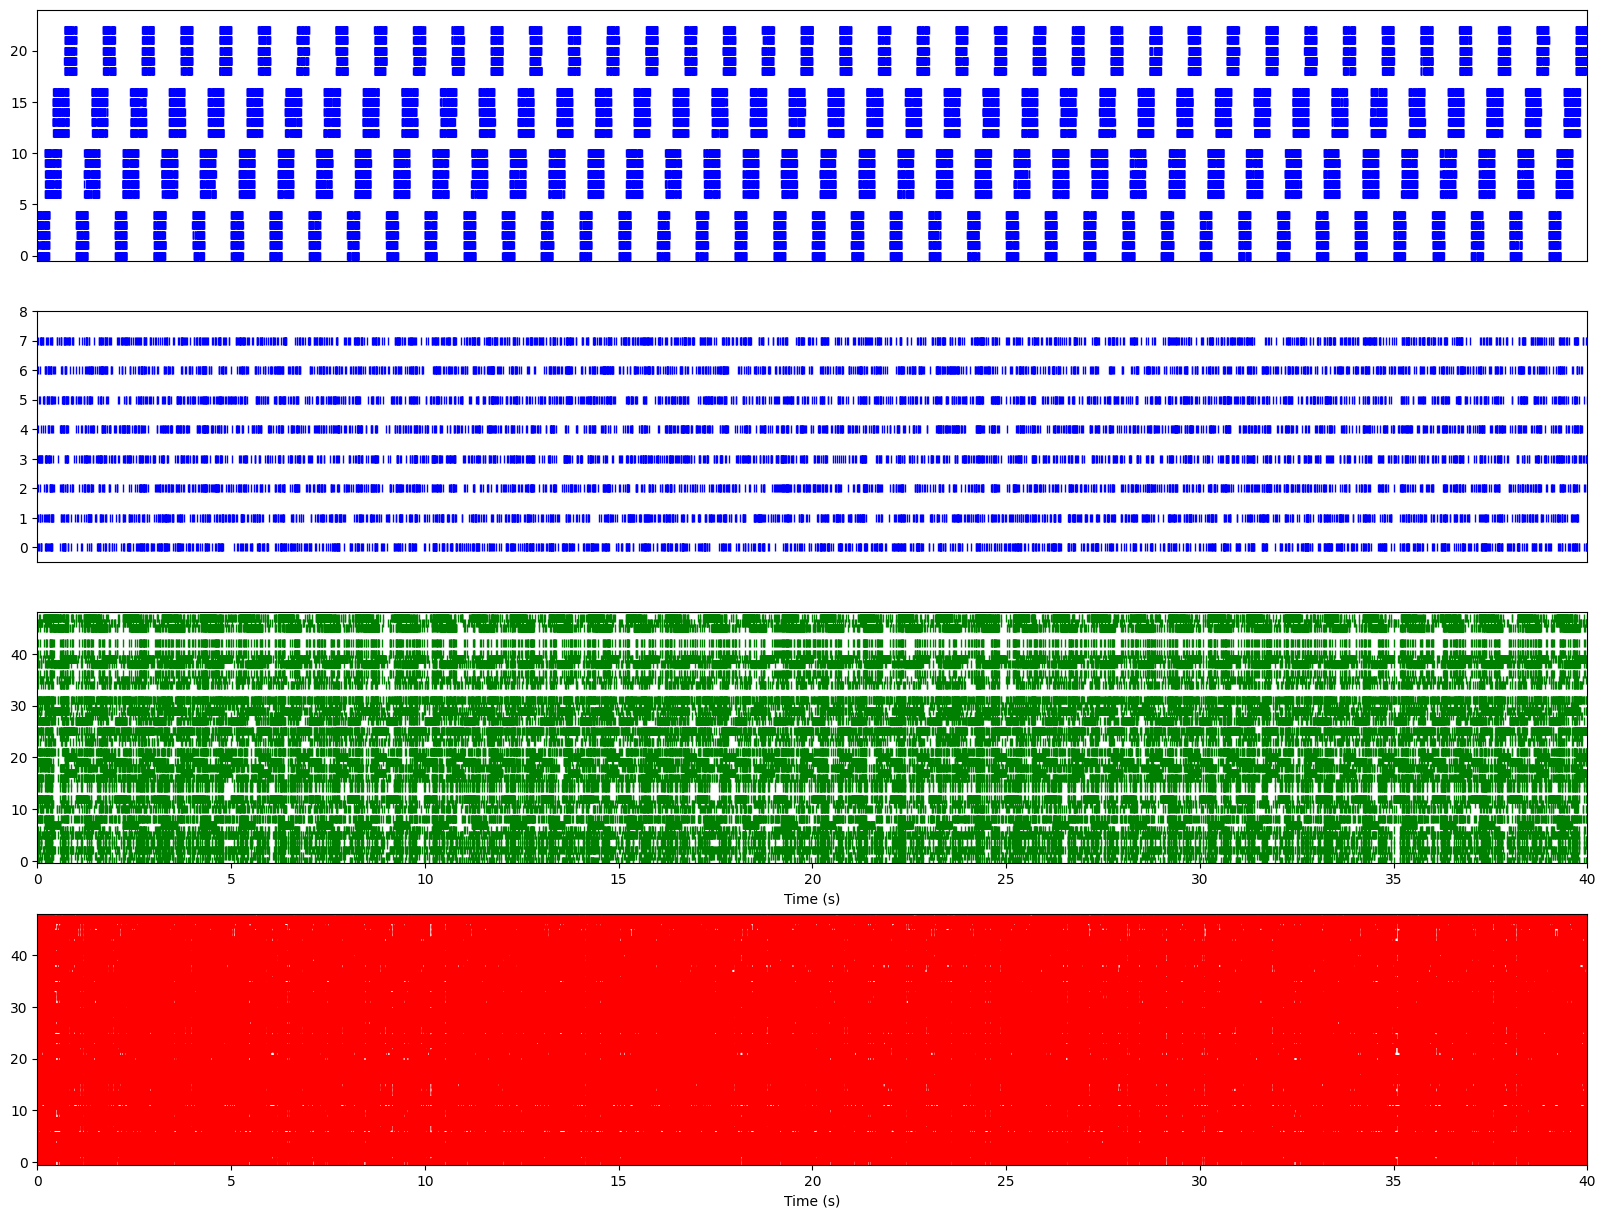

In [ ]:
render_start = step_duration * 0.0 * ms
render_duration = (step_duration*steps_num) * ms

figure(figsize=(20, 15))

subplot(411)
plot(cut_times, cut_indices, 'b|')
xlim([render_start/second, render_duration/second])
ylim([-0.5, cut_fibers_num])
xticks([])

subplot(412)
plot(muscle_times, muscle_indices, 'b|')
xlim([render_start/second, render_duration/second])
ylim([-0.5, muscle_fibers_num])
xticks([])

subplot(413)
plot(rg_times, rg_indices, 'g|')
xlim([render_start/second, render_duration/second])
ylim([-0.5, rg_num])
xlabel('Time (s)')

subplot(414)
plot(motor_times, motor_indices, 'r|')
xlim([render_start/second, render_duration/second])
ylim([-0.5, motor_num])
xlabel('Time (s)')

show()

## Weights

In [ ]:
render_start    = (step_duration*15) * ms 
render_duration = (step_duration*steps_num) * ms

avg_w = average(synapse_stdp_monitor.s.T, axis=1)
smoothed_0_w = savgol_filter(avg_w, 500, 4)

figure(figsize=(20, 20))

subplot(611)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, '-')
xlim([render_start/second, render_duration/second])
ylabel('Synaptic\nstrength s(t)')
xlabel('Time (s)')

subplot(612)
plot(synapse_stdp_monitor.t/second, smoothed_0_w, '-')
xlim([render_start/second, render_duration/second])
tight_layout()

#subplot(613)
#plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
#xlim([render_start/second, render_duration/second])
#ylabel('Eligibility\ntrace c(t)')
#xticks([])

show()

## Voltages

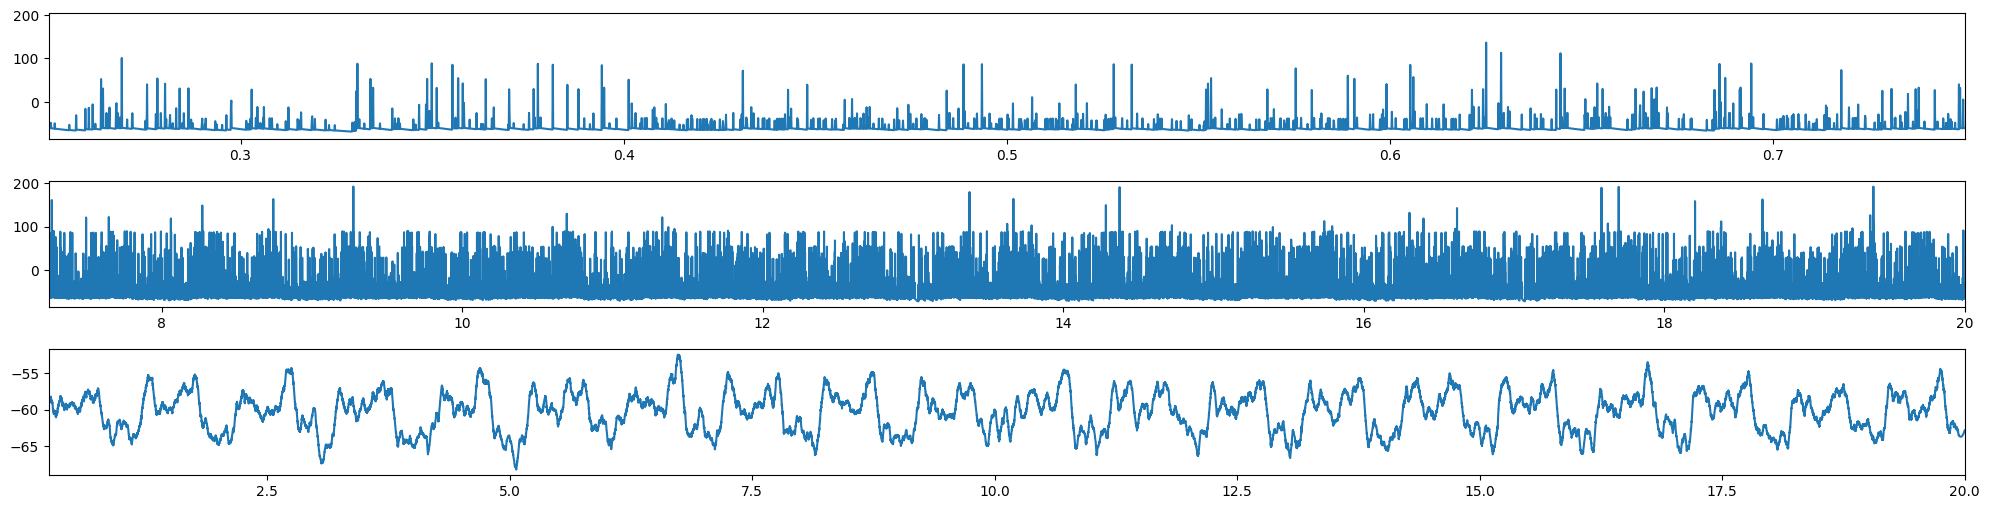

In [ ]:

render_start = (step_duration*0.250) * ms 
render_duration = (step_duration*0.750) * ms
total_render_duration = step_duration * steps_num

render_start1 = (step_duration*7.250) * ms 
render_duration1 = (step_duration*20.00) * ms

## avg and smoothing
avg_motor = average(motor_neurons_voltages.v.T, axis=1)
smoothed_0_motor = savgol_filter(avg_motor, 500, 6)
smoothed_1_motor = savgol_filter(avg_motor, 1200, 2)

figure(figsize=(20, 10))

subplot(611)
plot(motor_neurons_voltages.t/second, avg_motor/mV)
xlim([render_start/second, render_duration/second])
tight_layout()

subplot(612)
plot(motor_neurons_voltages.t/second, avg_motor/mV)
xlim([render_start1/second, render_duration1/second])
tight_layout()

subplot(613)
plot(motor_neurons_voltages.t/second, smoothed_1_motor/mV)
xlim([render_start/second, render_duration1/second])
tight_layout()


show()